In [28]:
import numpy as np
import random
import copy
import math
import gym
from gym import spaces
import torch
import torch.nn as nn
import torch.optim as optim

machine_pool = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 15]

# Danh sách các job ban đầu (jobs_initial)
jobs_initial = {
    1: [
        {'op_id': 1, 'candidate_machines': [1, 2], 'processing_time': 12}
    ],
    2: [
        {'op_id': 1, 'candidate_machines': [1, 2], 'processing_time': 12}
    ],
    3: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 1},
        {'op_id': 2, 'candidate_machines': [6], 'processing_time': 8},
        {'op_id': 3, 'candidate_machines': [6], 'processing_time': 8}
    ],
    4: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 7}
    ],
    5: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 1}
    ],
    6: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 1},
        {'op_id': 2, 'candidate_machines': [6], 'processing_time': 8},
        {'op_id': 3, 'candidate_machines': [6], 'processing_time': 8}
    ],
    7: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 7}
    ],
    8: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 1},
        {'op_id': 2, 'candidate_machines': [6], 'processing_time': 8},
        {'op_id': 3, 'candidate_machines': [6], 'processing_time': 8}
    ],
    9: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 7}
    ],
    10: [
        {'op_id': 1, 'candidate_machines': [3, 4], 'processing_time': 7}
    ]
}

# due_dates_initial: tất cả các job đều có due_date = 1200, sử dụng dict comprehension
due_dates_initial = {i: 1200 for i in range(1, 51)}

In [29]:
# Dummy simulated_annealing: tạo lịch trình ban đầu dưới dạng dictionary.
def simulated_annealing(jobs, due_dates, lambda_tardiness=1.0, **kwargs):
    # Khởi tạo thời gian sẵn sàng của các máy
    machine_ready = {m: 0 for m in machine_pool}
    schedule = {}
    # Với mỗi job, duyệt các operation theo thứ tự
    for job, ops in jobs.items():
        job_ready = 0  # Thời gian job sẵn sàng cho operation tiếp theo
        for i, op in enumerate(ops):
            best_machine = None
            best_start = None
            best_finish = float('inf')
            # Chọn máy trong candidate có thể bắt đầu sớm nhất
            for m in op['candidate_machines']:
                st = max(job_ready, machine_ready[m])
                ft = st + op['processing_time']
                if ft < best_finish:
                    best_finish = ft
                    best_start = st
                    best_machine = m
            schedule[(job, i)] = (best_start, best_finish, best_machine)
            job_ready = best_finish
            machine_ready[best_machine] = best_finish
    makespan = max(ft for (st, ft, m) in schedule.values())
    total_tardiness = sum(max(0, schedule[(job, i)][1] - due_dates[job])
                          for job in jobs for i in range(len(jobs[job])))
    cost = makespan + lambda_tardiness * total_tardiness
    return None, schedule, makespan, total_tardiness, cost, None

# Chuyển schedule dictionary sang list các event
def schedule_dict_to_list(schedule_dict, jobs_info):
    events = []
    for (job, op_index), (s, f, m) in schedule_dict.items():
        op_info = jobs_info[job]['operations'][op_index]
        event = {
            'job': job,
            'op_index': op_index,
            'start': s,
            'finish': f,
            'machine': m,
            'op_id': op_info['op_id'],
            'candidate_machines': op_info['candidate_machines']
        }
        events.append(event)
    events = sorted(events, key=lambda e: (str(e['job']), e['op_index'], e['start']))
    return events

# Hàm tách schedule (list event) theo current_time
def split_schedule_list(event_list, current_time, jobs_info):
    finished_events = []
    unfinished_jobs = {}
    jobs_events = {}
    for event in event_list:
        jobs_events.setdefault(event['job'], []).append(event)
    for job, events in jobs_events.items():
        events = sorted(events, key=lambda e: (e['op_index'], e['start']))
        ops_list = []
        job_ready = None
        for event in events:
            if event['finish'] <= current_time:
                finished_events.append(event)
                job_ready = event['finish']
            elif event['start'] < current_time < event['finish']:
                finished_part = event.copy()
                finished_part['finish'] = current_time
                finished_events.append(finished_part)
                remaining_time = event['finish'] - current_time
                unfinished_op = {
                    'op_index': event['op_index'],
                    'op_id': event['op_id'],
                    'candidate_machines': event['candidate_machines'],
                    'processing_time': remaining_time
                }
                ops_list.append(unfinished_op)
                job_ready = current_time
                total_ops = len(jobs_info[job]['operations'])
                for op_index in range(event['op_index']+1, total_ops):
                    op = jobs_info[job]['operations'][op_index]
                    new_op = {
                        'op_index': op_index,
                        'op_id': op['op_id'],
                        'candidate_machines': op['candidate_machines'],
                        'processing_time': op['processing_time']
                    }
                    ops_list.append(new_op)
                break
            else:
                unfinished_op = {
                    'op_index': event['op_index'],
                    'op_id': event['op_id'],
                    'candidate_machines': event['candidate_machines'],
                    'processing_time': event['finish'] - event['start']
                }
                ops_list.append(unfinished_op)
                if job_ready is None:
                    job_ready = current_time
        if ops_list:
            unfinished_jobs[job] = {
                'job_ready': job_ready,
                'due_date': jobs_info[job]['due_date'],
                'operations': ops_list
            }
    return finished_events, unfinished_jobs

# Các hàm reschedule heuristic cho phần unfinished:
def reschedule_unfinished_jobs_edd(unfinished_jobs, current_time, finished_events, machine_pool):
    # Áp dụng EDD nhưng có thể kết hợp thêm processing time
    sorted_jobs = sorted(unfinished_jobs.items(), key=lambda x: (x[1]['due_date'], sum(op['processing_time'] for op in x[1]['operations'])))
    new_events = []
    machine_ready = {m: current_time for m in machine_pool}
    for job, info in sorted_jobs:
        job_ready = info['job_ready']
        for op in sorted(info['operations'], key=lambda op: op['op_index']):
            pt = op['processing_time']
            best_start = float('inf')
            best_finish = float('inf')
            best_machine = None
            for m in op['candidate_machines']:
                st = max(job_ready, machine_ready.get(m, current_time))
                ft = st + pt
                if ft < best_finish:
                    best_finish = ft
                    best_start = st
                    best_machine = m
            event = {
                'job': job,
                'op_index': op['op_index'],
                'start': best_start,
                'finish': best_finish,
                'machine': best_machine,
                'op_id': op['op_id'],
                'candidate_machines': op['candidate_machines']
            }
            new_events.append(event)
            job_ready = best_finish
            machine_ready[best_machine] = best_finish
    return new_events

def reschedule_unfinished_jobs_sa(unfinished_jobs, current_time, finished_events, machine_pool, iterations=50):
    # Sử dụng SA với cooling schedule động và số iterations cao hơn.
    current_solution = reschedule_unfinished_jobs_edd(unfinished_jobs, current_time, finished_events, machine_pool)
    current_cost = max(e['finish'] for e in (finished_events + current_solution))
    T = 100  # Nhiệt độ khởi đầu
    cooling_rate = 0.95
    best_solution = current_solution
    best_cost = current_cost
    for i in range(iterations):
        # Tạo neighbor bằng cách thay đổi ngẫu nhiên một vài event trong current_solution
        neighbor = copy.deepcopy(current_solution)
        # Ví dụ: thay đổi finish của một event
        if neighbor:
            idx = random.randint(0, len(neighbor)-1)
            neighbor[idx]['finish'] *= random.uniform(1.0, 1.05)
        merged = finished_events + neighbor
        makespan = max(e['finish'] for e in merged) if merged else 0
        new_cost = makespan  # Giả sử tardiness không thay đổi
        if new_cost < best_cost or random.random() < math.exp(-(new_cost - current_cost)/T):
            current_solution = neighbor
            current_cost = new_cost
            if new_cost < best_cost:
                best_solution = neighbor
                best_cost = new_cost
        T *= cooling_rate
    return best_solution

def reschedule_unfinished_jobs_ga(unfinished_jobs, current_time, finished_events, machine_pool, num_candidates=10, generations=5):
    # Khởi tạo quần thể ban đầu từ hàm EDD
    population = [reschedule_unfinished_jobs_edd(unfinished_jobs, current_time, finished_events, machine_pool) for _ in range(num_candidates)]
    def evaluate(solution):
        merged = finished_events + solution
        return max(e['finish'] for e in merged)  # makespan
    for gen in range(generations):
        # Selection: chọn top 50% cá thể tốt nhất
        population = sorted(population, key=evaluate)[:max(1, num_candidates//2)]
        new_population = []
        # Crossover: tạo ra các cá thể mới từ các cặp
        while len(new_population) < num_candidates:
            parent1, parent2 = random.sample(population, 2)
            child = []
            for e1, e2 in zip(parent1, parent2):
                child.append(e1 if random.random() < 0.5 else e2)
            new_population.append(child)
        # Mutation: thay đổi ngẫu nhiên một vài event trong mỗi cá thể
        for solution in new_population:
            if random.random() < 0.3:
                idx = random.randint(0, len(solution)-1)
                solution[idx]['finish'] *= random.uniform(0.95, 1.05)
        population = new_population
    best_solution = min(population, key=evaluate)
    return best_solution

def reschedule_unfinished_jobs_pso(unfinished_jobs, current_time, finished_events, machine_pool, num_particles=10, iterations=20):
    # Định nghĩa hàm cost: ở đây ta sử dụng makespan của lịch trình (merged)
    def cost_function(candidate):
        merged = finished_events + candidate
        return max(e['finish'] for e in merged) if merged else 0

    # Khởi tạo population (các candidate solution) dựa trên kết quả EDD có nhiễu
    particles = []
    velocities = []
    base_candidate = reschedule_unfinished_jobs_edd(unfinished_jobs, current_time, finished_events, machine_pool)
    for i in range(num_particles):
        candidate = copy.deepcopy(base_candidate)
        # Thêm nhiễu cho mỗi candidate
        for event in candidate:
            event['finish'] *= random.uniform(0.95, 1.05)
        particles.append(candidate)
        velocities.append([0]*len(candidate))

    pbest = copy.deepcopy(particles)
    pbest_costs = [cost_function(p) for p in particles]
    gbest = min(particles, key=cost_function)
    gbest_cost = cost_function(gbest)

    w = 0.5    # inertia weight
    c1 = 1.0   # cognitive coefficient
    c2 = 1.0   # social coefficient

    # PSO loop
    for it in range(iterations):
        for i in range(num_particles):
            for j in range(len(particles[i])):
                current_finish = particles[i][j]['finish']
                pbest_finish = pbest[i][j]['finish']
                gbest_finish = gbest[j]['finish']
                r1 = random.random()
                r2 = random.random()
                new_velocity = w * velocities[i][j] + c1 * r1 * (pbest_finish - current_finish) + c2 * r2 * (gbest_finish - current_finish)
                velocities[i][j] = new_velocity
                particles[i][j]['finish'] = current_finish + new_velocity
            cost_candidate = cost_function(particles[i])
            if cost_candidate < pbest_costs[i]:
                pbest[i] = copy.deepcopy(particles[i])
                pbest_costs[i] = cost_candidate
        candidate_costs = [cost_function(p) for p in particles]
        min_cost = min(candidate_costs)
        if min_cost < gbest_cost:
            gbest = copy.deepcopy(particles[candidate_costs.index(min_cost)])
            gbest_cost = min_cost
    return gbest

# Hàm tạo unified job info cho các job ban đầu
def create_unified_jobs_info(jobs_initial, due_dates_initial):
    info = {}
    for job, ops in jobs_initial.items():
        info[job] = {
            'operations': ops,
            'due_date': due_dates_initial[job]
        }
    return info


In [33]:
# --- Bước 1: Tạo lịch trình ban đầu cho các job tĩnh bằng SA ---
_, init_schedule, _, _, _, _ = simulated_annealing(jobs_initial, due_dates_initial, lambda_tardiness=1.0)
all_jobs_info = create_unified_jobs_info(jobs_initial, due_dates_initial)
current_schedule_events = schedule_dict_to_list(init_schedule, all_jobs_info)

print("Initial Schedule:")
for event in current_schedule_events:
    print({
         'job': event['job'],
         'op_index': event['op_index'],
         'start': round(event['start'],2),
         'finish': round(event['finish'],2),
         'machine': event['machine']
    })

# --- Bước 2: Định nghĩa các dynamic job theo thông tin cho trước ---
dynamic_jobs = [
    {
        'job_id': 'D1',
        'arrival_time': 7,
        'due_date': 150,
        'operations': [
            {'op_id': 1, 'candidate_machines': [1, 4, 6], 'processing_time': 44},
            {'op_id': 2, 'candidate_machines': [4], 'processing_time': 7},
            {'op_id': 3, 'candidate_machines': [1, 3, 4, 6], 'processing_time': 28}
        ],
        'job_type': 'Normal'
    },
    {
        'job_id': 'D2',
        'arrival_time': 15,
        'due_date': 165,
        'operations': [
            {'op_id': 1, 'candidate_machines': [2, 4], 'processing_time': 26},
            {'op_id': 2, 'candidate_machines': [3], 'processing_time': 10},
            {'op_id': 3, 'candidate_machines': [4], 'processing_time': 47},
        ],
        'job_type': 'Normal'
    }
]



# --- Bước 3: Xử lý từng dynamic job bằng SA reschedule ---
for dj in dynamic_jobs:
    current_time = dj['arrival_time']
    # Tách lịch trình hiện tại thành phần finished và unfinished tại thời điểm current_time
    finished_events, unfinished_jobs = split_schedule_list(current_schedule_events, current_time, all_jobs_info)
    
    # Thêm dynamic job vào unified info và unfinished_jobs
    dyn_info = {
        'job_ready': current_time,
        'due_date': dj['due_date'],
        'operations': [
            {'op_index': i, 'op_id': op['op_id'], 'candidate_machines': op['candidate_machines'], 'processing_time': op['processing_time']}
            for i, op in enumerate(dj['operations'])
        ]
    }
    all_jobs_info[dj['job_id']] = dyn_info
    unfinished_jobs[dj['job_id']] = dyn_info
    
    # Sử dụng SA để reschedule phần unfinished
    new_unfinished_events = reschedule_unfinished_jobs_sa(unfinished_jobs, current_time, finished_events, machine_pool)
    
    # Ghép lại thành lịch trình mới
    current_schedule_events = finished_events + new_unfinished_events
    
    print(f"\nAfter adding dynamic job {dj['job_id']} at time {current_time}:")
    for event in current_schedule_events:
         print({
             'job': event['job'],
             'op_index': event['op_index'],
             'start': round(event['start'],2),
             'finish': round(event['finish'],2),
             'machine': event['machine']
         })

# --- Bước 4: In kết quả cuối cùng và vẽ Gantt Chart ---
print("\nFinal Schedule:")
for event in current_schedule_events:
    print({
        'job': event['job'],
        'op_index': event['op_index'],
        'start': round(event['start'],2),
        'finish': round(event['finish'],2),
        'machine': event['machine']
    })

final_makespan = max(e['finish'] for e in current_schedule_events)
print("\nFinal Makespan:", round(final_makespan,2))

# Vẽ Gantt Chart cho lịch trình cuối cùng


Initial Schedule:
{'job': 1, 'op_index': 0, 'start': 0, 'finish': 12, 'machine': 1}
{'job': 10, 'op_index': 0, 'start': 10, 'finish': 17, 'machine': 3}
{'job': 2, 'op_index': 0, 'start': 0, 'finish': 12, 'machine': 2}
{'job': 3, 'op_index': 0, 'start': 0, 'finish': 1, 'machine': 3}
{'job': 3, 'op_index': 1, 'start': 1, 'finish': 9, 'machine': 6}
{'job': 3, 'op_index': 2, 'start': 9, 'finish': 17, 'machine': 6}
{'job': 4, 'op_index': 0, 'start': 0, 'finish': 7, 'machine': 4}
{'job': 5, 'op_index': 0, 'start': 1, 'finish': 2, 'machine': 3}
{'job': 6, 'op_index': 0, 'start': 2, 'finish': 3, 'machine': 3}
{'job': 6, 'op_index': 1, 'start': 17, 'finish': 25, 'machine': 6}
{'job': 6, 'op_index': 2, 'start': 25, 'finish': 33, 'machine': 6}
{'job': 7, 'op_index': 0, 'start': 3, 'finish': 10, 'machine': 3}
{'job': 8, 'op_index': 0, 'start': 7, 'finish': 8, 'machine': 4}
{'job': 8, 'op_index': 1, 'start': 33, 'finish': 41, 'machine': 6}
{'job': 8, 'op_index': 2, 'start': 41, 'finish': 49, 'machi

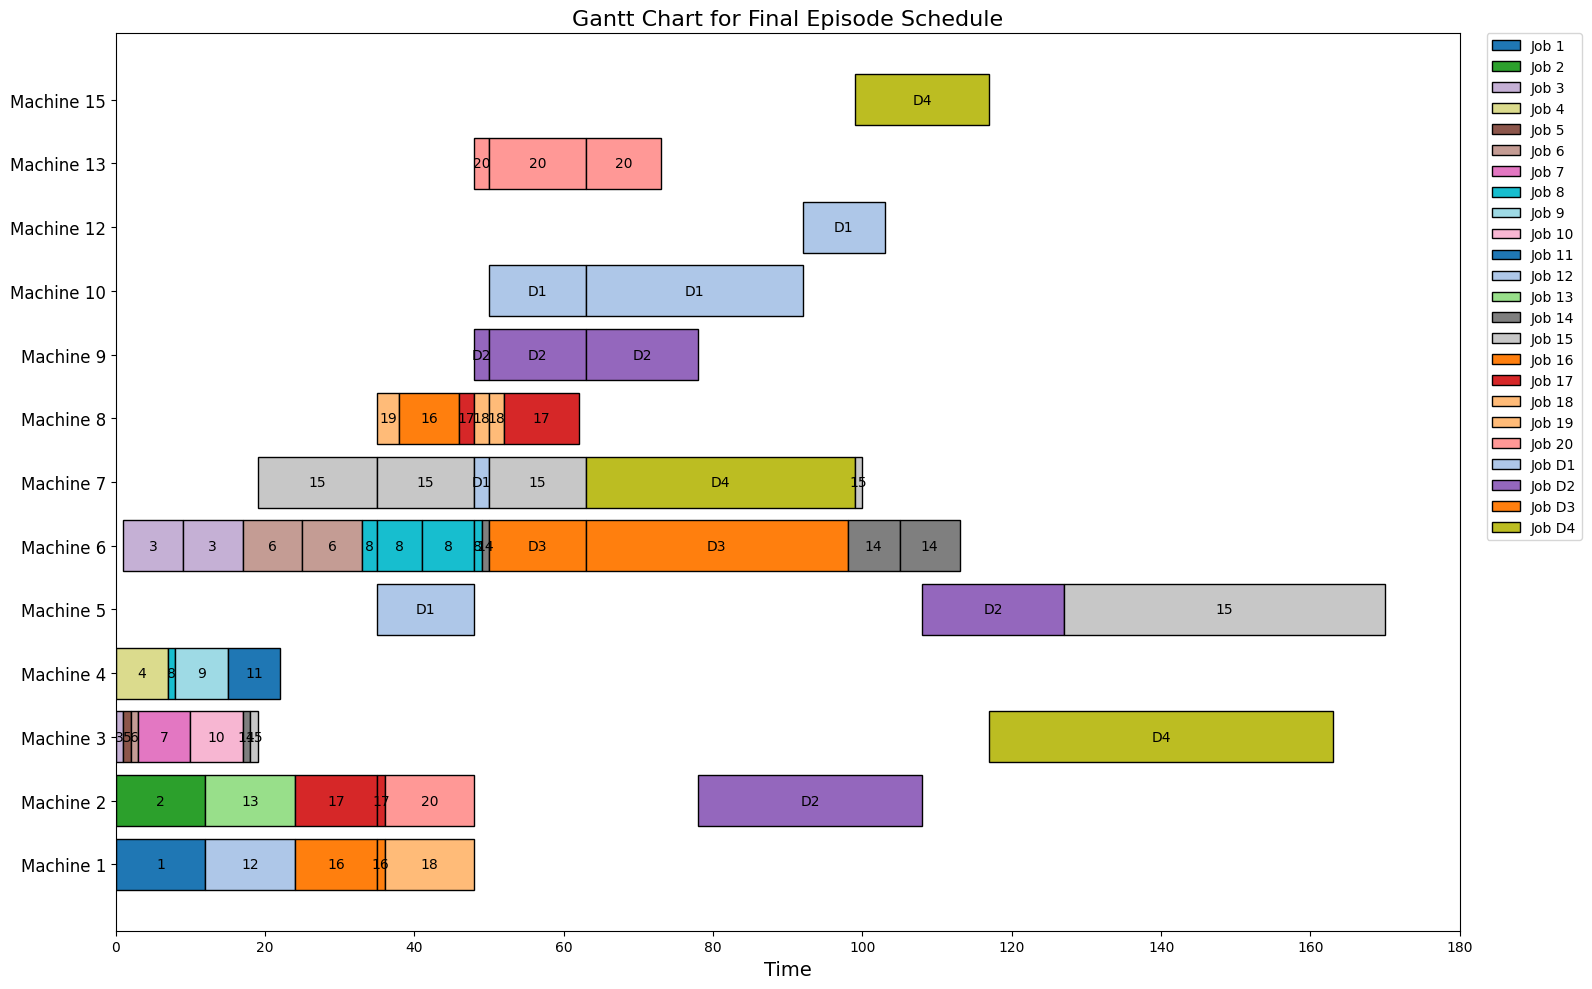

In [13]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def plot_gantt(schedule_events):
    colors = plt.cm.tab20.colors
    job_colors = {}

    def get_job_color(job):
        job = str(job)
        if job not in job_colors:
            index = len(job_colors) % len(colors)
            job_colors[job] = colors[index]
        return job_colors[job]

    machines = {}
    for event in schedule_events:
        m = event['machine']
        machines.setdefault(m, []).append(event)

    machine_ids = sorted(machines.keys())
    fig, ax = plt.subplots(figsize=(16, 10))

    yticks = []
    ytick_labels = []
    bar_height = 0.8

    for i, m in enumerate(machine_ids):
        yticks.append(i)
        ytick_labels.append(f"Machine {m}")
        events = sorted(machines[m], key=lambda e: e['start'])
        for event in events:
            start = event['start']
            finish = event['finish']
            duration = finish - start
            job = event['job']
            color = get_job_color(job)
            ax.barh(i, duration, left=start, height=bar_height, align='center', color=color, edgecolor='black')
            ax.text(start + duration/2, i, f"{job}", color='black', ha='center', va='center', fontsize=10)

    ax.set_yticks(yticks)
    ax.set_yticklabels(ytick_labels, fontsize=12)
    ax.set_xlabel("Time", fontsize=14)
    ax.set_title("Gantt Chart for Final Episode Schedule", fontsize=16)

    max_finish = max(e['finish'] for e in schedule_events) if schedule_events else 0
    ax.set_xlim(0, max_finish + 10)

    def sort_key(job_id):
        try:
            return (0, int(job_id))
        except ValueError:
            if job_id.startswith("D"):
                return (1, int(job_id[1:]))
            return (1, job_id)

    sorted_jobs = sorted(job_colors.items(), key=lambda item: sort_key(item[0]))
    legend_elements = [Patch(facecolor=color, edgecolor='black', label=f"Job {job}") for job, color in sorted_jobs]
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0.)

    plt.tight_layout()
    plt.show()

# Giả sử bạn đã có lịch trình cuối cùng trong current_schedule_events
# Ví dụ, current_schedule_events có được sau quá trình inference hoặc training
# Dưới đây là ví dụ gọi hàm plot_gantt:
plot_gantt(current_schedule_events)

In [14]:
print("\nTardiness per job:")
for job, info in all_jobs_info.items():
    # Lấy các event của job từ final schedule
    job_events = [e for e in current_schedule_events if e['job'] == job]
    if job_events:
        comp_time = max(e['finish'] for e in job_events)
        # Nếu job không có thuộc tính 'job_type', ta coi là 'Normal'
        job_type = info.get('job_type', 'Normal')
        tardiness = max(0, comp_time - info['due_date'])
        print(f"Job {job} ({job_type}): Completion = {round(comp_time,2)}, Due = {info['due_date']}, Tardiness = {round(tardiness,2)}")



Tardiness per job:
Job 1 (Normal): Completion = 12, Due = 1200, Tardiness = 0
Job 2 (Normal): Completion = 12, Due = 1200, Tardiness = 0
Job 3 (Normal): Completion = 17, Due = 1200, Tardiness = 0
Job 4 (Normal): Completion = 7, Due = 1200, Tardiness = 0
Job 5 (Normal): Completion = 2, Due = 1200, Tardiness = 0
Job 6 (Normal): Completion = 33, Due = 1200, Tardiness = 0
Job 7 (Normal): Completion = 10, Due = 1200, Tardiness = 0
Job 8 (Normal): Completion = 49, Due = 1200, Tardiness = 0
Job 9 (Normal): Completion = 15, Due = 1200, Tardiness = 0
Job 10 (Normal): Completion = 17, Due = 1200, Tardiness = 0
Job 11 (Normal): Completion = 22, Due = 1200, Tardiness = 0
Job 12 (Normal): Completion = 24, Due = 1200, Tardiness = 0
Job 13 (Normal): Completion = 24, Due = 1200, Tardiness = 0
Job 14 (Normal): Completion = 113, Due = 1200, Tardiness = 0
Job 15 (Normal): Completion = 170, Due = 1200, Tardiness = 0
Job 16 (Normal): Completion = 46, Due = 1200, Tardiness = 0
Job 17 (Normal): Completion =